In [10]:
import os
import numpy as np

# Pull phasing data
chromosome = '22'
family_ids, Xs, Ys, row_indices, col_indices = [], [], [], [], []
for filename in os.listdir('raw_data'):
    if filename.endswith('%s.npz' % chromosome):
        data = np.load('raw_data/%s' % filename)
        if 'X' in data and 'Y' in data and 'row_indices' in data and 'col_indices' in data:
            family_ids.append(filename.split('.')[0])
            Xs.append(data['X'])
            Ys.append(data['Y'])
            row_indices.append(data['row_indices'])
            col_indices.append(data['col_indices'])
print(len(Xs))

808


In [11]:
# Pull variants
variants = []
with open('data/v34.%s.txt' % chromosome, 'r') as f:
    for line in f:
        variants.append(int(line.strip()))

variants = np.asarray(variants)
print(variants[:10], variants[-10:])

[16050007 16050036 16050102 16050115 16050116 16050129 16050137 16050159
 16050199 16050213] [51244381 51244396 51244420 51244435 51244437 51244443 51244509 51244510
 51244515 51244529]


In [12]:
m = 4*len(family_ids)
n = len(variants)
print(m, n)

3232 1096536


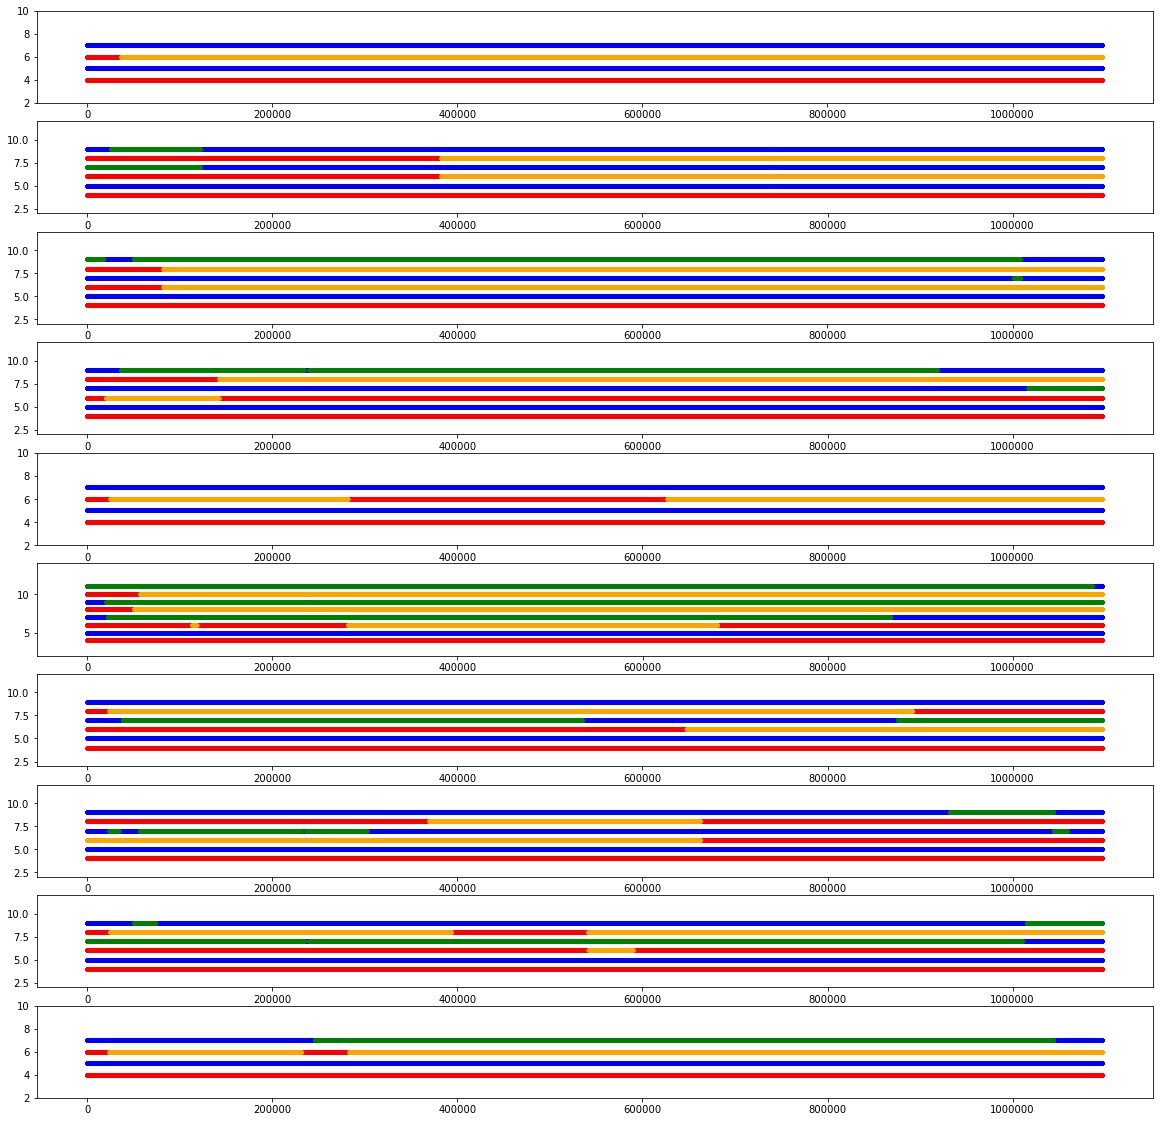

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))

n = 10
for k, X in enumerate(Xs[:n]):
    if X is not None:
        m, _, _ = X.shape
    
        plt.subplot(n, 1, k+1)
        for i in range(2, m):
            plt.plot(col_indices[k], 2*i*X[i, 0, :], linestyle='None', marker='.', color='red')
            plt.plot(col_indices[k], 2*i*X[i, 1, :], linestyle='None', marker='.', color='orange')
            plt.plot(col_indices[k], 2*i*X[i, 2, :]+1, linestyle='None', marker='.', color='blue')
            plt.plot(col_indices[k], 2*i*X[i, 3, :]+1, linestyle='None', marker='.', color='green')
            
        axes = plt.gca()
        axes.set_ylim([2,(m+1)*2])

plt.show()

In [24]:
chromosome = '20'
maternal_recombinations = []
paternal_recombinations = []
with open('data/recomb%s.txt' % chromosome, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if pieces[1] == 'M':
            maternal_recombinations.append(int(pieces[0]))
        else:
            paternal_recombinations.append(int(pieces[0]))
print(len(maternal_recombinations), len(paternal_recombinations))  


5048 4463


In [25]:
# Pull variants
variants = []
with open('data/v34.%s.txt' % chromosome, 'r') as f:
    for line in f:
        variants.append(int(line.strip()))
variants = np.asarray(variants)
print(variants[:10], variants[-10:])

[60039 60097 60175 60309 60343 60415 60474 60479 60483 60499] [62965299 62965354 62965361 62965365 62965366 62965384 62965478 62965480
 62965513 62965516]


In [26]:
# Pull recombination rate from Kong paper
# https://www.ncbi.nlm.nih.gov/pubmed/12053178?dopt=Abstract&holding=npg

kong_x = []
kong_y = []
kong_y_female = []
kong_y_male = []

with open('data/recombRate.txt') as f:
    for line in f:
        pieces = line.split('\t')
        chrom = pieces[0]
        start, end = [int(x) for x in pieces[1:3]]
        avg_rec, avg_rec_female, avg_rec_male = [float(x) for x in pieces[4:7]]
        
        if chrom == 'chr' + chromosome:
            kong_x.append(start)
            kong_x.append(end)
            kong_y.append(avg_rec)
            kong_y.append(avg_rec)
            kong_y_female.append(avg_rec_female)
            kong_y_female.append(avg_rec_female)
            kong_y_male.append(avg_rec_male)
            kong_y_male.append(avg_rec_male)
        

In [27]:
# Pull recombination rate from Bherer paper
# https://github.com/cbherer/Bherer_etal_SexualDimorphismRecombination

bherer_x = []
bherer_y = []
bherer_x_female = []
bherer_y_female = []
bherer_x_male = []
bherer_y_male = []

with open('data/Refined_genetic_map_b37/sexavg_chr%s.txt' % chromosome, 'r') as f:
    next(f) # skip header
    for line in f:
        pieces = line.split('\t')
        pos = int(pieces[1])
        rr = float(pieces[2])
        
        bherer_x.append(pos)
        bherer_y.append(rr)

current_bin = 0
with open('data/Refined_genetic_map_b37/female_chr%s.txt' % chromosome, 'r') as f:
    next(f) # skip header
    for line in f:
        pieces = line.split('\t')
        pos = int(pieces[1])
        rr = float(pieces[2])
        
        bherer_x_female.append(pos)
        bherer_y_female.append(rr)
        
current_bin = 0
with open('data/Refined_genetic_map_b37/male_chr%s.txt' % chromosome, 'r') as f:
    next(f) # skip header
    for line in f:
        pieces = line.split('\t')
        pos = int(pieces[1])
        rr = float(pieces[2])
        
        bherer_x_male.append(pos)
        bherer_y_male.append(rr)
        

In [28]:
telomeres = []
centromeres = []

with open('data/b37.gaps') as f:
    next(f) # discard header
    for line in f:
        pieces = line.strip().split('\t')
        ch, start, end, marker_type = pieces[1][3:], pieces[2], pieces[3], pieces[7]
        if ch == chromosome:
            if marker_type == 'telomere':
                telomeres.extend(list(range(int(start), int(end), 10000)))
            elif marker_type == 'centromere':
                centromeres.extend(list(range(int(start), int(end), 10000)))


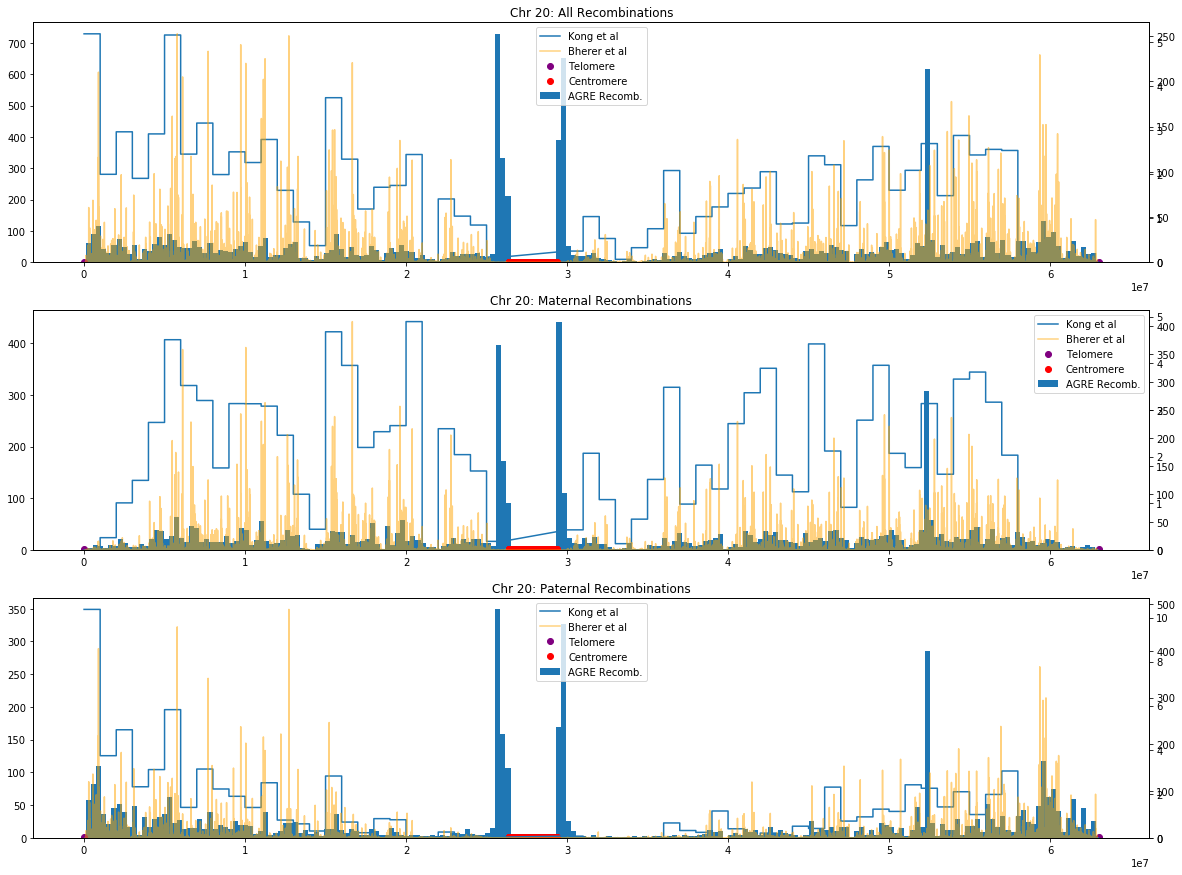

In [29]:
plt.figure(figsize=(20, 15))

both_recombinations = maternal_recombinations + paternal_recombinations
both_recombinations.sort()

ax1 = plt.subplot(3, 1, 1)
ax1.hist(variants[both_recombinations], bins=200, label='AGRE Recomb.')
ax1.plot(telomeres, [1]*len(telomeres), label='Telomere', linestyle='None', marker='o', c='purple')
ax1.plot(centromeres, [1]*len(centromeres), label='Centromere', linestyle='None', marker='o', c='red')
ax2 = ax1.twinx()
ax2.plot(kong_x, kong_y, label='Kong et al')
ax2.set_ylim(bottom=0)
ax3 = ax1.twinx()
ax3.plot(bherer_x, bherer_y, label='Bherer et al', c='orange', alpha=0.5)
ax3.set_ylim(bottom=0)
plt.title('Chr %s: All Recombinations' % chromosome)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax3.legend(lines2 + lines3 + lines, labels2 + labels3 + labels, loc=0)

ax1 = plt.subplot(3, 1, 2)
ax1.hist(variants[maternal_recombinations], bins=200, label='AGRE Maternal Recomb.')
ax1.plot(telomeres, [1]*len(telomeres), label='Telomere', linestyle='None', marker='o', c='purple')
ax1.plot(centromeres, [1]*len(centromeres), label='Centromere', linestyle='None', marker='o', c='red')
ax2 = ax1.twinx()
ax2.plot(kong_x, kong_y_female, label='Kong et al')
ax2.set_ylim(bottom=0)
ax3 = ax1.twinx()
ax3.plot(bherer_x_female, bherer_y_female, label='Bherer et al', c='orange', alpha=0.5)
ax3.set_ylim(bottom=0)
ax3.legend(lines2 + lines3 + lines, labels2 + labels3 + labels, loc=0)
plt.title('Chr %s: Maternal Recombinations' % chromosome)

ax1 = plt.subplot(3, 1, 3)
ax1.hist(variants[paternal_recombinations], bins=200, label='AGRE Paternal Recomb.')
ax1.plot(telomeres, [1]*len(telomeres), label='Telomere', linestyle='None', marker='o', c='purple')
ax1.plot(centromeres, [1]*len(centromeres), label='Centromere', linestyle='None', marker='o', c='red')
ax2 = ax1.twinx()
ax2.plot(kong_x, kong_y_male, label='Kong et al')
ax2.set_ylim(bottom=0)
ax3 = ax1.twinx()
ax3.plot(bherer_x_male, bherer_y_male, label='Bherer et al', c='orange', alpha=0.5)
ax3.set_ylim(bottom=0)
ax3.legend(lines2 + lines3 + lines, labels2 + labels3 + labels, loc=0)
plt.title('Chr %s: Paternal Recombinations' % chromosome)

plt.show()

In [255]:
print(variants[:10])

[10023, 10067, 10072, 10085, 10101, 10105, 10129, 10134, 10135, 10166]


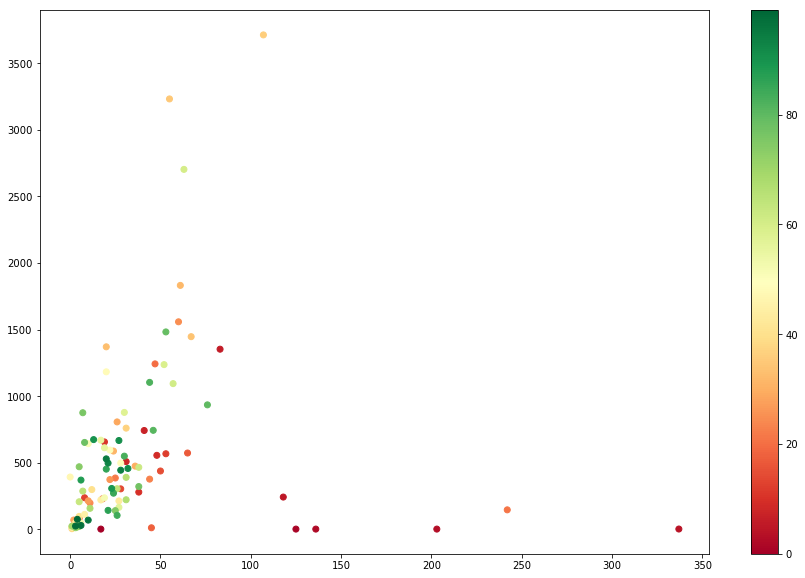

In [196]:
nbin = 100

bins = list(range(0, len(variants), int(round(len(variants)/nbin))))
variant_bins = [variants[i] for i in bins]
recrate = [0]*len(bins)

current_bin = 0
with open('data/Refined_genetic_map_b37/female_chr%s.txt' % chromosome, 'r') as f:
    next(f) # skip header
    for line in f:
        pieces = line.split('\t')
        pos = int(pieces[1])
        rr = float(pieces[2])
        
        while variant_bins[current_bin+1] < pos and current_bin+2 < len(bins):
            current_bin += 1
            
        recrate[current_bin] += rr

plt.figure(figsize=(15,10))
hist, bin_edges = np.histogram(maternal_recombinations, bins=nbin)
ax1 = plt.subplot(1, 1, 1)
plt.scatter(hist, recrate[:nbin], c=range(nbin), cmap='RdYlGn')
plt.colorbar()
#ax1.set_ylim([0, 1000])
#ax1.set_xlim([0, 50])
plt.show()

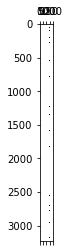

In [453]:
Y = np.load('data/Y22.npz')

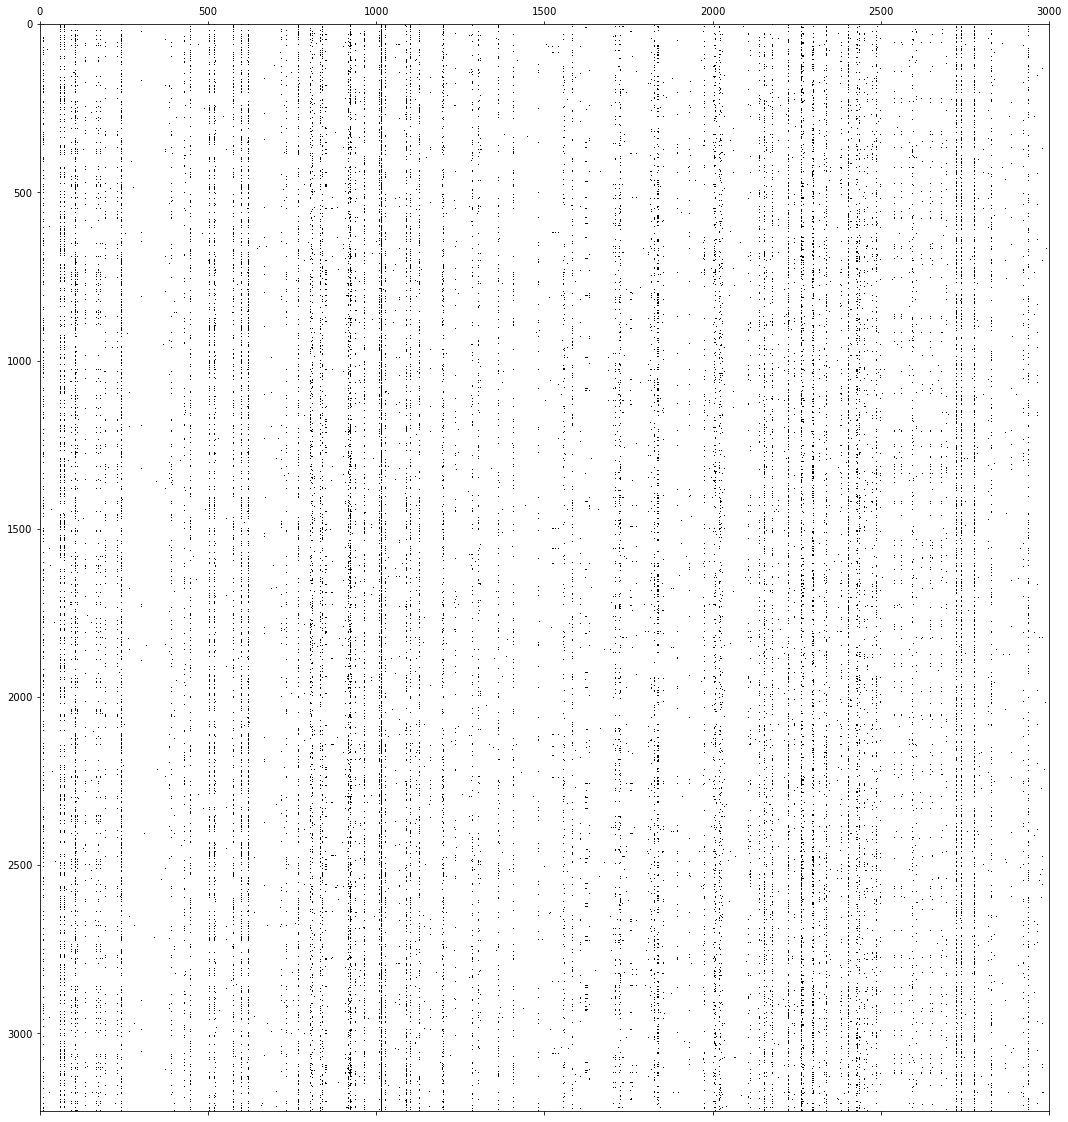

In [455]:
plt.figure(figsize=(20,20))
plt.spy(Y['Y'][:, :3000])
plt.show()